### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define problem parameters
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)

# Number of chains and Gibbs samples
C, G = 2, 10000  
theta, tau = np.zeros((C, G)), np.zeros((C, G))

# Initialization
theta[:, 0] = np.random.normal(0, 1, size=C)  # Prior for theta
tau[:, 0] = np.random.gamma(shape=2, scale=1, size=C)  # Prior for tau

for c in range(C):
    for g in range(1, G):
        # **Step 1: Update tau given theta**
        tau_proposal = stats.gamma(a=2, scale=1).rvs()  # Gamma proposal for tau

        # Compute acceptance probability for tau
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1], scale=1/(tau_**0.5)).pdf(x)) * stats.gamma(a=2, scale=1).pdf(tau_)
        
        mh_tau = (tau_target(tau_proposal) / tau_target(tau[c, g-1]))  
        accept_tau = min(1, mh_tau)
        
        # Accept/reject tau
        tau[c, g] = tau_proposal if np.random.uniform() < accept_tau else tau[c, g-1]

        # **Step 2: Update theta given tau**
        theta_proposal = stats.norm(loc=theta[c, g-1], scale=0.5).rvs()  # Normal proposal

        # Compute acceptance probability for theta
        theta_target = lambda theta_: np.prod(stats.norm(loc=theta_, scale=1/(tau[c, g]**0.5)).pdf(x)) * stats.norm(0, 1).pdf(theta_)
        
        mh_theta = (theta_target(theta_proposal) / theta_target(theta[c, g-1]))  
        accept_theta = min(1, mh_theta)
        
        # Accept/reject theta
        theta[c, g] = theta_proposal if np.random.uniform() < accept_theta else theta[c, g-1]

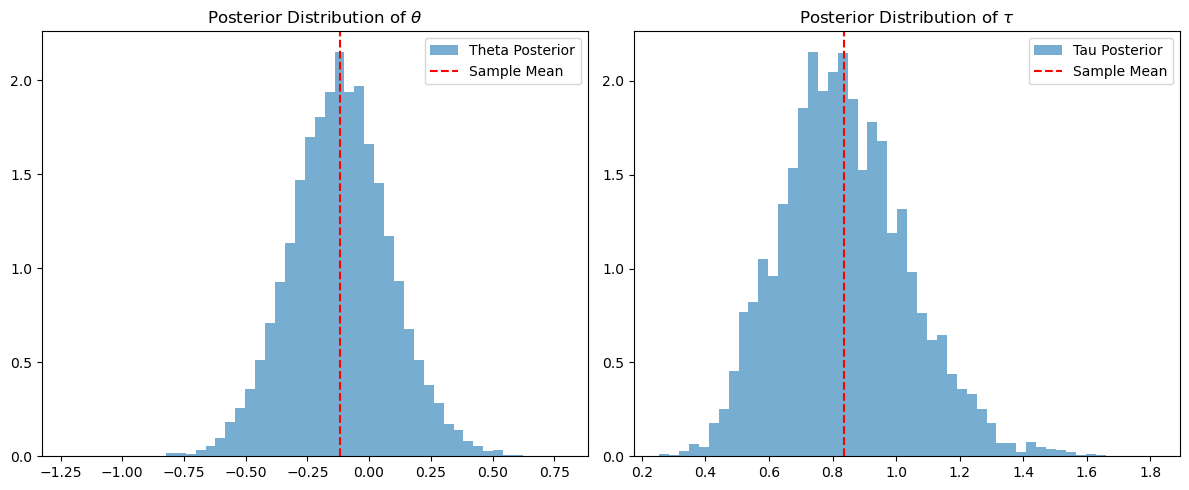

In [2]:
# Plot posterior distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot posterior of theta
axes[0].hist(theta.flatten(), bins=50, density=True, alpha=0.6, label="Theta Posterior")
axes[0].axvline(np.mean(theta), color="red", linestyle="--", label="Sample Mean")
axes[0].set_title(r"Posterior Distribution of $\theta$")
axes[0].legend()

# Plot posterior of tau
axes[1].hist(tau.flatten(), bins=50, density=True, alpha=0.6, label="Tau Posterior")
axes[1].axvline(np.mean(tau), color="red", linestyle="--", label="Sample Mean")
axes[1].set_title(r"Posterior Distribution of $\tau$")
axes[1].legend()

plt.tight_layout()
plt.show()

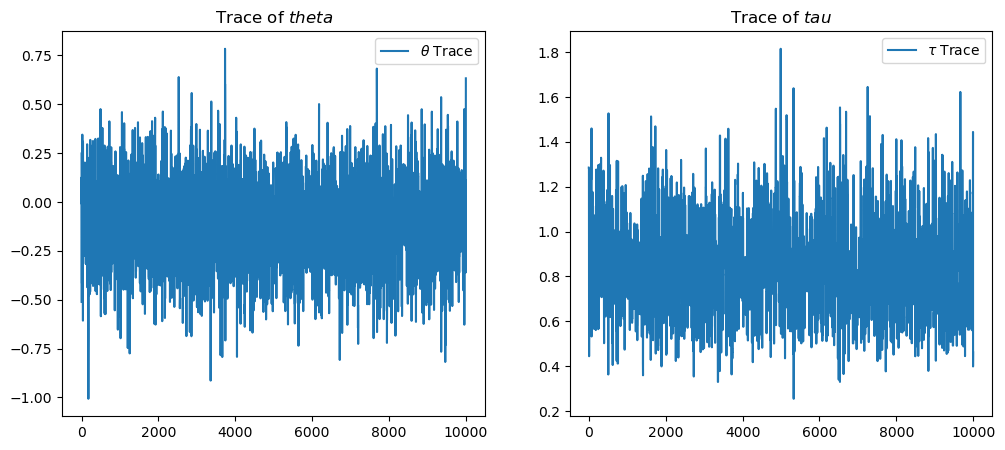

In [4]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(theta[0, :], label=r'$\theta$ Trace')
ax[0].set_title("Trace of $theta$")
ax[0].legend()

ax[1].plot(tau[0, :], label=r'$\tau$ Trace')
ax[1].set_title("Trace of $tau$")
ax[1].legend()

plt.show()


### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

### Updated Metropolis within Gibbs:
1. instead of using gamma distribution for tau proposal, using dependent proposal tau. 
2. Prior for $\theta$ also changed to t-distribution. 

In [6]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

# Define problem parameters
n = 30
x = stats.norm(loc=0, scale=1).rvs(size=n)

# Number of chains and Gibbs samples
C, G = 2, 10000  
theta, tau = np.zeros((C, G)), np.zeros((C, G))

# Initialization
theta[:, 0] = stats.t(df=3).rvs(size=C)  # Student-t prior for theta
tau[:, 0] = np.random.gamma(shape=2, scale=1, size=C)  # Prior for tau

s = 0.5  # Scale parameter for truncated normal proposal

for c in range(C):
    for g in range(1, G):
        # Step 1: Update tau using Truncated Normal Proposal
        tau_t_minus_1 = tau[c, g-1]
        a, b = -tau_t_minus_1 / s, np.inf
        tau_proposal = stats.truncnorm(a=a, b=b, loc=tau_t_minus_1, scale=s).rvs()
        
        # Compute acceptance probability for tau
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1], scale=1/(tau_**0.5)).pdf(x)) * stats.gamma(a=2, scale=1).pdf(tau_)
        
        mh_tau = (tau_target(tau_proposal) / tau_target(tau[c, g-1]))  
        accept_tau = min(1, mh_tau)
        
        # Accept/reject tau
        tau[c, g] = tau_proposal if np.random.uniform() < accept_tau else tau[c, g-1]

        # **Step 2: Update theta given tau using Normal Proposal**
        theta_proposal = stats.norm(loc=theta[c, g-1], scale=0.5).rvs()

        # Compute acceptance probability for theta with Student-t prior
        nu = 3  # Degrees of freedom for Student-t prior
        theta_target = lambda theta_: np.prod(stats.norm(loc=theta_, scale=1/(tau[c, g]**0.5)).pdf(x)) * stats.t(df=nu).pdf(theta_)
        
        mh_theta = (theta_target(theta_proposal) / theta_target(theta[c, g-1]))  
        accept_theta = min(1, mh_theta)
        
        # Accept/reject theta
        theta[c, g] = theta_proposal if np.random.uniform() < accept_theta else theta[c, g-1]


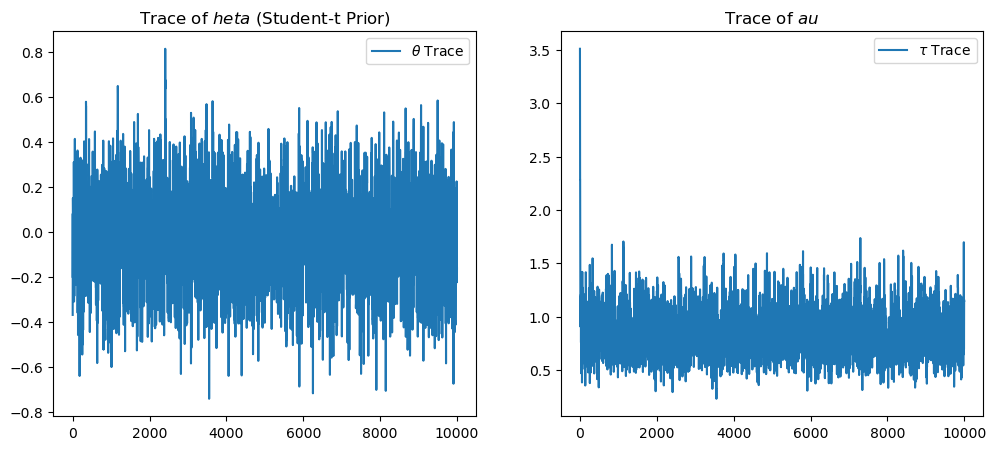

In [7]:
# Plot results
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(theta[0, :], label=r'$\theta$ Trace')
ax[0].set_title("Trace of $\theta$ (Student-t Prior)")
ax[0].legend()

ax[1].plot(tau[0, :], label=r'$\tau$ Trace')
ax[1].set_title("Trace of $\tau$")
ax[1].legend()

plt.show()

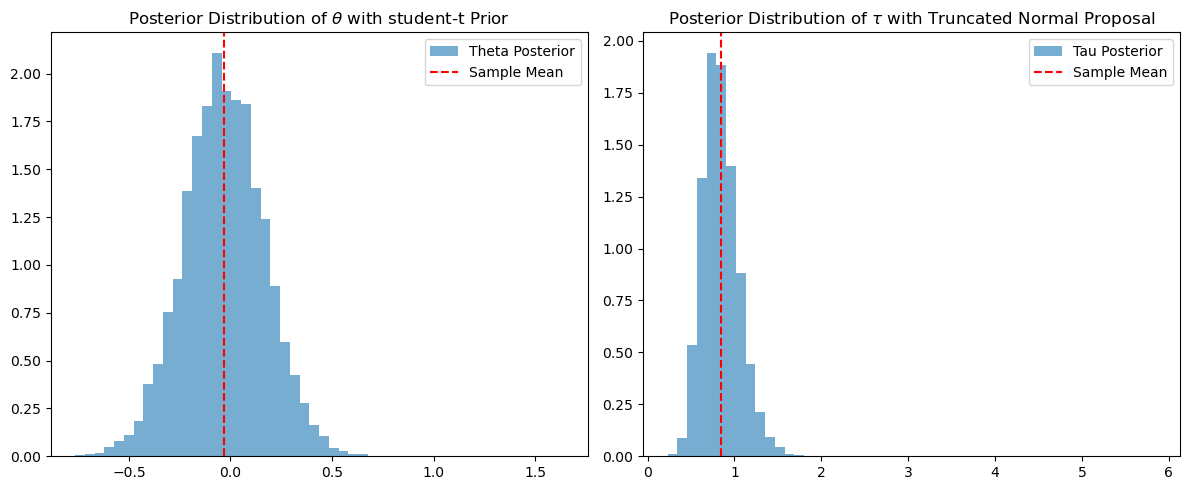

In [9]:
# Plot posterior distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot posterior of theta
axes[0].hist(theta.flatten(), bins=50, density=True, alpha=0.6, label="Theta Posterior")
axes[0].axvline(np.mean(theta), color="red", linestyle="--", label="Sample Mean")
axes[0].set_title(r"Posterior Distribution of $\theta$ with student-t Prior")
axes[0].legend()

# Plot posterior of tau
axes[1].hist(tau.flatten(), bins=50, density=True, alpha=0.6, label="Tau Posterior")
axes[1].axvline(np.mean(tau), color="red", linestyle="--", label="Sample Mean")
axes[1].set_title(r"Posterior Distribution of $\tau$ with Truncated Normal Proposal")
axes[1].legend()

plt.tight_layout()
plt.show()

### Discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.

When using Metropolis-Hastings, it is not always necessary to get the full conditional distributions. We propose a candidate dample and direct sample from it while we also need to decide whether to accept or reject it. In this case, we use joint probability distribution(likelihood* prior) instead of full conditional distribution. By using Metroplis-Hastings, it is quite usefull if the full conditional is hard to derive, or full conditional distribution is not a standard distribition.  

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

This means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


### Solution: 
Firstly, to check if  
$\begin{align}
\quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}\\
\end{align}$

The proposal transition probabilities are given as:

$$
q(\tilde{x}^{(t)} | x^{(t-1)}) = \left(\frac{1}{2}\right)^{1-\tilde{x}^{(t)}} \left(\frac{1}{2}\right)^{\tilde{x}^{(t)}}
$$

$$
q(x^{(t-1)} | \tilde{x}^{(t)}) = \left(\frac{1}{2}\right)^{1-x^{(t-1)}} \left(\frac{1}{2}\right)^{x^{(t-1)}}
$$

As the exponent term of $1-x^{t-1}$ ensures the probability term is still 1/2 if $x^{t-1}$ is 0. Similarly, if $x^{t-1}$ is 1, then $1-x^{t-1}$ is 0 to get our probability still 1/2.

Therefore, we conclude that both proposals are symmetric (they are always $\frac{1}{2}$), their ratio cancels out:

$$
\frac{q(x^{(t-1)} | x^{(t)})}{q(x^{(t)} | x^{(t-1)})} = 1
$$

Thus, **the proposal ratio cancels out**.

Thus,we have the acceptance probability simplifies to:

$$
\alpha = \min \left( 1, \frac{p(x^{(t)})}{p(x^{(t-1)})} \right)
$$

Since the proposal ratio cancels, the only relevant term left in the Metropolis-Hastings step is the ratio of the target stationary distribution values.

In addition, to further understand the proposal transition probability for following implication: 
$$ q(x^{(t-1)} | \tilde{x}^{(t)})$$ would mean that the current state is $\tilde{x}^{(t)}$ and the probability of moving to state $x^{(t-1)}$ is $q(x^{(t-1)} | \tilde{x}^{(t)})$. 


### Then, to show that: 
the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$

As given example of coin flip, $x^t$ has the value of either 0 or 1 (binary values). 
The transition kernel K could be derived from getting the product of propoal probability 

### Step 1: Compute the Acceptance Probability

From above explanation, the Metropolis-Hastings acceptance probability is:

  $$
  \alpha(x^{(t-1)} \to \tilde{x}^{(t)}) = \min \left( 1, \frac{p(\tilde{x}^{(t)})}{p(x^{(t-1)})} \right)
  $$

We are given: Target distribution is 
  $$
  p(x^{(t)}) = \left( \frac{1}{3} \right)^{1 - x^{(t)}} \left( \frac{2}{3} \right)^{x^{(t)}}
  $$
Computing the ratios:

- If transitioning from \( 0 \) to \( 1 \):

  $$
  \frac{p(1)}{p(0)} = \frac{\frac{2}{3}}{\frac{1}{3}} = 2
  $$

  So,

  $$
  \alpha(0 \to 1) = \min(1, 2) = 1
  $$

- If transitioning from \( 1 \) to \( 0 \):

  $$
  \frac{p(0)}{p(1)} = \frac{\frac{1}{3}}{\frac{2}{3}} = \frac{1}{2}
  $$

  So,

  $$
  \alpha(1 \to 0) = \min(1, \frac{1}{2}) = \frac{1}{2}
  $$

### Step 2: Compute Transition Probabilities (kernel matrix)
Using:

  $$
  K(x^{(t)} \to x^{(t+1)}) = q(x^{(t+1)} | x^{(t)}) \alpha(x^{(t)} \to x^{(t+1)})
  $$

- **For \( K(0 to 0) \)**:

  $$
  K(0 \to 0) = q(0 | 0) \alpha(0 \to 0) + q(1 | 0) (1 - \alpha(0 \to 1))
  $$

  $$
  = 0.5(1)+ 0.5(0) = 0.5
  $$

- **For \( K(0 to 1) \)**:

  $$
  K(0 \to 1) = q(1 | 0) \alpha(0 \to 1) = 0.5 \times 1 = 0.5
  $$

- **For \( K(1 to 0) \)**:

  $$
  K(1 \to 0) = q(0 | 1) \alpha(1 \to 0) = 0.5 \times \frac{1}{2} = 0.25
  $$

- **For \( K(1 to 1) \)**:

  $$
  K(1 \to 1) = q(1 | 1) \alpha(1 \to 1) + q(0 | 1) (1 - \alpha(1 \to 0))
  $$

  $$
  = 0.5(1) + 0.5(1 - \frac{1}{2}) = 0.5 + 0.25 = 0.75
  $$

Thus, the transition matrix is:

  $$
  K =
  \begin{bmatrix}
  0.5 & 0.5 \\
  0.25 & 0.75
  \end{bmatrix}
  $$
